# Models Pipeline

We want to see how different models affect our dataset.

In [1]:
from preprocessing import load_dataset, split_dataset, grid_search, feature_interaction_polynomyal_degreee2, corresponding_features_interaction, corresponding_features_custom_interaction
from utilities import plot_grid_results, print_log
import models

We define the generic parameters, to be used to split the dataset.

In [2]:
test_size = 0.2         # the ratio of the dataset we want to use as test set
stratify = True         # Whether we want the split to keep the same proportion between classes as the original dataset
k = 5                   # The number of folds for the (stratified) k fold 

First of all, we load the dataset and we split it into training and test set (to be used only in the end).

We also apply different feature transformations to see if they improve our results.

In [8]:
# first, we load the dataset
X, y = load_dataset('./data/data.pkl')
# then, we split it
X_tr, y_tr, X_te, y_te = split_dataset(X, y, test=test_size, stratify=stratify)

# generate the dataset version with polynomyal features of degree 2
X_tr_poly = feature_interaction_polynomyal_degreee2(X_tr)

# generate the dataset version containing corresponding features interaction (the product)
# for example: (interest in music of x) * (interest in music of y)
X_tr_int_only = corresponding_features_custom_interaction(X_tr, drop=True)
X_tr_int_full = corresponding_features_custom_interaction(X_tr, drop=False)

# generate the dataset version containing the result of a custom function that
# consider features interaction rewarding shared interests and penalizing unmatched interests
X_tr_custom_int_only = corresponding_features_custom_interaction(X_tr, drop=True)
X_tr_custom_int_full = corresponding_features_custom_interaction(X_tr, drop=False)


Now, we can start to try the grid search with different models, to see how it behaves.

Notice we want to have high __*recall*__ for class 'MATCH' (that is, we want to detect as many MATCH samples as possible). For this reason, we put recall as main metric for our grid search.

## K-Nearest Neighbors

We run a grid search on the kNN model, trying values of k from 1 to 10. Since our data is highly dimensional, we expect such an algorithm to perform bad.

### 1. No interactions, no PCA

In [4]:
# get pipeline 
pipe, grid = models.scaling(models.knn)
# call grid_search
out_knn = grid_search(X_tr, y_tr, pipe, grid, k)

print_log(out_knn)

Best model (according to recall): {'model__n_neighbors': 1}
-----------------------------------------
Recall : 0.22121566335476328
Balanced accuracy: 0.5368385842256359
f1: 0.21913922867942187


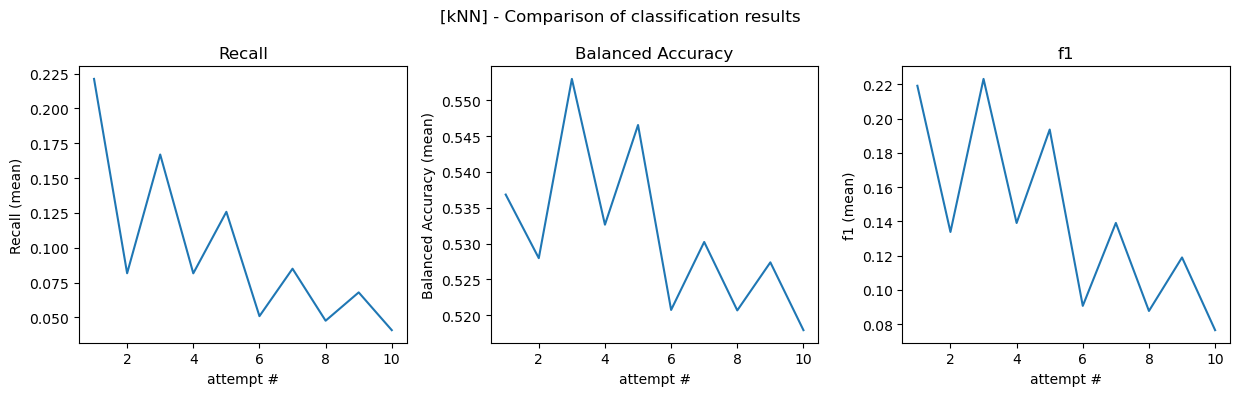

In [5]:
# Plot recall, balanced accuracy and f1 metric for every k in the range
plot_grid_results(out_knn, 'kNN')

### 2. Polynomial transformation, over sampling and PCA

In [6]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 58], model_f = models.knn)
# call grid_search
out_knn = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(out_knn)

Best model (according to recall): {'model__n_neighbors': 9, 'pca__n_components': 58}
-----------------------------------------
Recall : 0.5782583284628873
Balanced accuracy: 0.5973368099797529
f1: 0.31672830304362914


### 3. Interactions only, over sampling and PCA

In [15]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 58], model_f = models.knn)
# call grid_search
out_knn = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(out_knn)

Best model (according to recall): {'model__n_neighbors': 9}
-----------------------------------------
Recall : 0.7175336060783168
Balanced accuracy: 0.5323319929999241
f1: 0.2733470726181845


### 4. Custom interactions only, over sampling

In [12]:
# get pipeline 
pipe, grid = models.over_sampling(models.knn)
# call grid_search
out_knn = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(out_knn)

Best model (according to recall): {'model__n_neighbors': 9}
-----------------------------------------
Recall : 0.7417299824663939
Balanced accuracy: 0.5485103452285836
f1: 0.28329502656145117


### 5. Custom interactions only, over sampling, PCA

In [14]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 58], model_f = models.knn)
# call grid_search
out_knn = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(out_knn)

Best model (according to recall): {'model__n_neighbors': 7, 'pca__n_components': 58}
-----------------------------------------
Recall : 0.47293980128579777
Balanced accuracy: 0.5801470757774585
f1: 0.2991676828879009


## Logistic Regression

Normal Logistic Regression does not converge. We try some strategies to reduce the dimensionality of our data.

### 1. Polynomial transformation, scaling

In [18]:
# get pipeline 
pipe, grid = models.scaling(models.logistic_regression)
# call grid_search
out_lr_drop = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(out_lr_drop)

Best model (according to recall): {'model__C': 10000}
-----------------------------------------
Recall : 0.3573933372296902
Balanced accuracy: 0.6096444022951748
f1: 0.33483231530533963


### 2. Interactions only, scaling

In [19]:
# get pipeline 
pipe, grid = models.scaling(models.logistic_regression)
# call grid_search
out_lr_drop = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(out_lr_drop)

Best model (according to recall): {'model__C': 10}
-----------------------------------------
Recall : 0.47609585037989477
Balanced accuracy: 0.5603720118601629
f1: 0.2793179893553591


### 3. Interactions only, over sampling and PCA

In [21]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[20, 30, 58], model_f=models.logistic_regression)
# call grid_search
out_lr_pca = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(out_lr_pca)

Best model (according to recall): {'model__C': 10000, 'pca__n_components': 30}
-----------------------------------------
Recall : 0.3299824663939217
Balanced accuracy: 0.5441448382126348
f1: 0.249877753703656


### 4. Custom interactions and scaling

In [26]:
# get pipeline 
pipe, grid = models.scaling(models.logistic_regression)
# call grid_search
out_lr_pca = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(out_lr_pca)

Best model (according to recall): {'model__C': 10}
-----------------------------------------
Recall : 0.47609585037989477
Balanced accuracy: 0.5603720118601629
f1: 0.2793179893553591


## Random Forest

### 1. Polynomial transformation, over sampling and scaling

In [27]:
# get pipeline 
pipe, grid = models.over_sampling(models.scaling, model_f = models.random_forest)
# call grid_search
out_rf = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(out_rf)

Best model (according to recall): {'model__criterion': 'entropy', 'model__min_samples_split': 2, 'model__n_estimators': 100}
-----------------------------------------
Recall : 0.15639976621858565
Balanced accuracy: 0.5637610904987371
f1: 0.23749153925103292


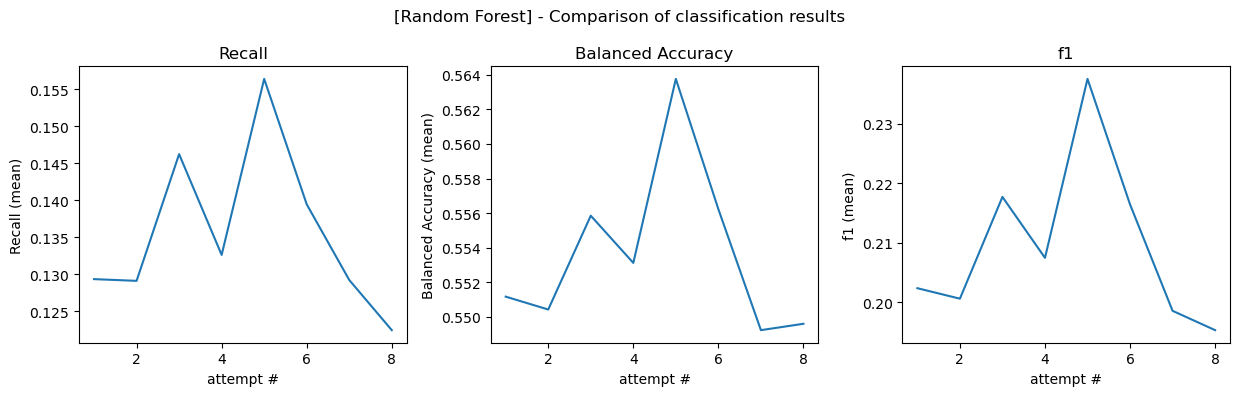

In [28]:
plot_grid_results(out_rf, 'Random Forest')

### 2. Interactions over sampling and scaling

In [29]:
# get pipeline 
pipe, grid = models.over_sampling(models.scaling, model_f = models.random_forest)
# call grid_search
out_rf = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(out_rf)

Best model (according to recall): {'model__criterion': 'entropy', 'model__min_samples_split': 5, 'model__n_estimators': 100}
-----------------------------------------
Recall : 0.10888369374634717
Balanced accuracy: 0.53812020494971
f1: 0.16883706924182224


### 3. Custom interactions and over sampling

In [31]:
# get pipeline 
pipe, grid = models.over_sampling(models.random_forest)
# call grid_search
out_rf = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(out_rf)

Best model (according to recall): {'model__criterion': 'entropy', 'model__min_samples_split': 5, 'model__n_estimators': 200}
-----------------------------------------
Recall : 0.1054354178842782
Balanced accuracy: 0.5351372195984748
f1: 0.16173064452324246
